In [80]:
from warnings import filterwarnings
filterwarnings(action='ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px

import scipy.stats as stats
from scipy.stats import zscore

from sklearn.preprocessing import LabelEncoder,OneHotEncoder,OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures,PowerTransformer,StandardScaler

from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

from sklearn.metrics import classification_report,accuracy_score,precision_score,confusion_matrix
from sklearn.metrics import recall_score,f1_score,balanced_accuracy_score,roc_curve
from sklearn.metrics import precision_recall_curve,log_loss,cohen_kappa_score,roc_auc_score

from sklearn.model_selection import StratifiedKFold,cross_val_score,train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.impute import KNNImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,VotingClassifier

from imblearn.over_sampling import SMOTE,SMOTEN,SMOTENC

import re

from sklearn.feature_selection import SelectKBest,VarianceThreshold

from fancyimpute import IterativeImputer,knn,IterativeSVD

In [81]:
from User_defined_functions import cv_report

In [82]:
link_imb = 'F:\GREAT LAKES\PROJECT\Different_datasets\Random Forest\Imbalanced_Dummy_encoded_data.csv'

In [83]:
link = 'F:\GREAT LAKES\PROJECT\CAPSTONE\Iterative_Imputatiof_diagnosis\Fully_finally_imputed_data.csv'

In [84]:
df = pd.read_csv(link_imb)
df = df.iloc[:,1:]

In [85]:
df_tree = df.copy()

In [86]:
patient_info = ['race', 'gender', 'age', 'admission_type_id',
                'discharge_disposition_id','admission_source_id',
                'medical_specialty','diagnosis_1','diagnosis_2', 'diagnosis_3',
                'max_glu_serum', 'A1Cresult','change', 'diabetesMed']

# Features which contains no information
drop_list_patient_info = ['encounter_id','patient_nbr','weight','payer_code']

# Numeric features
patient_info_numeric = ['time_in_hospital','num_lab_procedures',
                        'num_procedures','num_medications',
                        'number_outpatient','number_emergency',
                        'number_inpatient','number_diagnoses']

# Taking initial decision to keep 16 features
feature_medicine = ['metformin','repaglinide', 'nateglinide', 
                     'chlorpropamide', 'glimepiride', 'glipizide', 
                     'glyburide', 'tolbutamide','pioglitazone',
                     'rosiglitazone', 'acarbose', 'miglitol','tolazamide',
                     'insulin','glyburide-metformin', 'glipizide-metformin']

# Initial decision to remove 7 features
drop_list_medicine = ['acetohexamide','troglitazone','examide','citoglipton',
                      'glimepiride-pioglitazone','metformin-rosiglitazone',
                      'metformin-pioglitazone']


# The medicines which contains 'Steady' & 'No' for encoding purpose
two_category_medicine = ['acetohexamide', 'tolbutamide', 'troglitazone',
                         'glipizide-metformin', 'glimepiride-pioglitazone',
                         'metformin-rosiglitazone', 'metformin-pioglitazone']
# ------------------------------------------------------------------
# The medicines which contains 'Steady','Up','Down' & 'No' for encoding purpose (14)
four_category_medicine = ['metformin','repaglinide', 'nateglinide', 'chlorpropamide',
                          'glimepiride','glipizide','glyburide','pioglitazone','rosiglitazone',
                          'acarbose','miglitol','tolazamide','insulin','glyburide-metformin'] 
# ------------------------------------------------------------------
# considering these two medicines with only 'steady' & 'No' categories for encoding purpose
two_category_medicine_to_be_kept = ['tolbutamide','glipizide-metformin']
# ------------------------------------------------------------------                                                
# Out of initial removal decision, these 2 are compulsorily removed.
single_category_medicine = ['examide', 'citoglipton']
                                             

print(set(drop_list_medicine) & set(two_category_medicine))

dependent = 'readmitted'

{'acetohexamide', 'metformin-pioglitazone', 'glimepiride-pioglitazone', 'troglitazone', 'metformin-rosiglitazone'}


In [ ]:
One_hot_encoded = df_tree.dtypes[df.dtypes == 'object'].index.tolist()

In [ ]:
One_hot_encoded.remove('readmitted')

In [ ]:
Rf_dummy_transform = ColumnTransformer([('OHE',OneHotEncoder(sparse=False),
                                         One_hot_encoded)],remainder='passthrough')
encoded_data = Rf_dummy_transform.fit_transform(df_tree)

In [ ]:
# getting column names

category_encoded = Rf_dummy_transform.named_transformers_.OHE.get_feature_names_out()

In [ ]:
# creating a encoded Dataframe

df_tree = pd.DataFrame(encoded_data,columns=category_encoded.tolist()+patient_info_numeric+['readmitted'])

In [ ]:
df_tree['readmitted'] = df_tree['readmitted'].map({'Yes':1,'No':0})

In [129]:
# link_rf = 'F:\GREAT LAKES\PROJECT\CAPSTONE\SMOTE_NC_Random_Forest_data\Dummy_encoded_data.csv'

In [130]:
# df_tree.to_csv(link_rf)

In [ ]:
rf_oversample = SMOTENC(categorical_features=range(0,132))
predictor_rf, Target_rf = rf_oversample.fit_resample(Training_data,Target_imbalanced)

In [ ]:
predictor_rf.iloc[:,132:] = predictor_rf.iloc[:,132:].apply(lambda x : x.astype(int))

In [ ]:
df_rf = pd.concat([predictor_rf, Target_rf],axis=1)

In [173]:
# link_rf_nc = 'F:\GREAT LAKES\PROJECT\CAPSTONE\SMOTE_NC_Random_Forest_data\SMOTENC_Dummy_encoded_data.csv'

In [175]:
# df_rf.to_csv(link_rf_nc)

In [9]:
def cv_report(Model,Training_data,Target_imbalanced):
    X_train, X_test, y_train, y_test = train_test_split(Training_data,Target_imbalanced,
                                                        test_size=0.25, random_state=42,
                                                        stratify=Target_imbalanced)
    ba = cross_val_score(Model,X_train,y_train,cv=StratifiedKFold(),
                         scoring='balanced_accuracy').mean()
    pr = cross_val_score(Model,X_train,y_train,cv=StratifiedKFold(),scoring='precision').mean()
    re = cross_val_score(Model,X_train,y_train,cv=StratifiedKFold(),scoring='recall').mean()
    f1 = cross_val_score(Model,X_train,y_train,cv=StratifiedKFold(),scoring='f1').mean()
    print(f"Balanced accuracy : {ba}")
    print(f"Precision : {pr}")
    print(f"recall : {re}")
    print(f"F1-score : {f1}")

# `Random Forest (Imbalanced dataset)`

In [11]:
Training_data = df_tree.drop('readmitted',1)
Target_imbalanced = df_tree[['readmitted']]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(Training_data,Target_imbalanced, 
                                                    test_size=0.25, random_state=42,stratify=Target_imbalanced)

In [13]:
Rf = RandomForestClassifier(n_estimators=25,bootstrap=True,max_depth=30,max_samples=0.75,
                            class_weight='balanced')
Rf.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=30, max_samples=0.75,
                       n_estimators=25)

In [14]:
print(classification_report(y_train,Rf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     67253
           1       1.00      0.81      0.89      8485

    accuracy                           0.98     75738
   macro avg       0.99      0.90      0.94     75738
weighted avg       0.98      0.98      0.98     75738



In [15]:
print(classification_report(y_test,Rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     22418
           1       0.41      0.01      0.02      2829

    accuracy                           0.89     25247
   macro avg       0.65      0.50      0.48     25247
weighted avg       0.83      0.89      0.84     25247



In [13]:
cv_report(Rf,X_train,y_train)

Balanced accuracy : 0.5022647944676577
Precision : 0.5553434800493624
recall : 0.00392810031273622
F1-score : 0.01179434360671877


# `Random Forest after oversampling`

In [16]:
nclink_tree = 'F:\GREAT LAKES\PROJECT\Different_datasets\Random Forest\SMOTENC_Ordinal_encoded.csv'

In [17]:
df_nc = pd.read_csv(nclink_tree)
df_nc = df_nc.iloc[:,1:]

In [18]:
Training_data_nc = df_nc.drop('readmitted',1)
Target_balanced_nc = df_nc[['readmitted']]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(Training_data_nc,Target_balanced_nc, 
                                                    test_size=0.25,random_state=42)

In [20]:
Rf_nc = RandomForestClassifier(n_estimators=80,min_samples_split=45,max_depth=25,
                               max_features=0.65,max_samples=0.65,random_state=93,n_jobs=-1)
Rf_nc.fit(X_train,y_train)

RandomForestClassifier(max_depth=25, max_features=0.65, max_samples=0.65,
                       min_samples_split=45, n_estimators=80, n_jobs=-1,
                       random_state=93)

In [38]:
def cv_report_nc(Model,Training_data,Target_balanced):
    X_train, X_test, y_train, y_test = train_test_split(Training_data,Target_balanced,
                                                        test_size=0.25, random_state=42)
    ba = cross_val_score(Model,X_train,y_train,cv=5,
                         scoring='balanced_accuracy').mean()
    pr = cross_val_score(Model,X_train,y_train,cv=5,scoring='precision').mean()
    re = cross_val_score(Model,X_train,y_train,cv=5,scoring='recall').mean()
    f1 = cross_val_score(Model,X_train,y_train,cv=5,scoring='f1').mean()
    print("Metric            :  percentage")
    print("-"*35)
    print(f"Balanced accuracy :  {ba*100:0.2f} %")
    print(f"Precision         :  {pr*100:0.2f} %")
    print(f"recall            :  {re*100:0.2f} %")
    print(f"F1-score          :  {f1*100:0.2f} %")

In [39]:
cv_report_nc(Rf_nc,Training_data_nc,Target_balanced_nc)

Metric            :  percentage
-----------------------------------
Balanced accuracy :  82.94 %
Precision         :  85.55 %
recall            :  79.11 %
F1-score          :  82.20 %


In [21]:
print(classification_report(y_train,Rf_nc.predict(X_train)))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88     67423
           1       0.90      0.84      0.87     67083

    accuracy                           0.88    134506
   macro avg       0.88      0.88      0.88    134506
weighted avg       0.88      0.88      0.88    134506



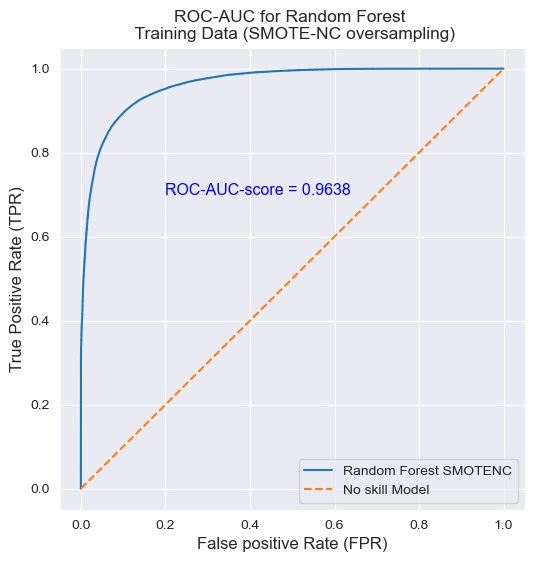

In [157]:
fpr, tpr, _ = roc_curve(y_train,Rf_nc.predict_proba(X_train)[:,1])

fig,ax = plt.subplots(figsize=(6,6))
sns.set_style('darkgrid')
plt.plot(fpr,tpr,label='Random Forest SMOTENC')
sns.lineplot([0,1],[0,1],label='No skill Model',ls='--')
plt.xlabel("False positive Rate (FPR)",fontsize=12.0)
plt.ylabel("True Positive Rate (TPR)",fontsize=12.0)
plt.text(0.2,0.7,s=f"ROC-AUC-score = {roc_auc_score(y_train,Rf_nc.predict_proba(X_train)[:,1]):0.4f}",
        fontsize=11.5,color='blue')
plt.title('ROC-AUC for Random Forest \n Training Data (SMOTE-NC oversampling)',fontsize=12.5)
plt.show()

In [210]:
def cv_report_nc(Model,Training_data,Target_imbalanced):
    X_train, X_test, y_train, y_test = train_test_split(Training_data,Target_imbalanced,
                                                        test_size=0.25, random_state=42)
    ba = cross_val_score(Model,X_train,y_train,cv=StratifiedKFold(),
                         scoring='balanced_accuracy').mean()
    pr = cross_val_score(Model,X_train,y_train,cv=StratifiedKFold(),scoring='precision').mean()
    re = cross_val_score(Model,X_train,y_train,cv=StratifiedKFold(),scoring='recall').mean()
    f1 = cross_val_score(Model,X_train,y_train,cv=StratifiedKFold(),scoring='f1').mean()
    print("Metric            :  percentage")
    print("-"*35)
    print(f"Balanced accuracy :  {ba*100:0.2f} %")
    print(f"Precision         :  {pr*100:0.2f} %")
    print(f"recall            :  {re*100:0.2f} %")
    print(f"F1-score          :  {f1*100:0.2f} %")

In [114]:
cv_report_nc(Rf_nc,X_train,y_train)

Metric            :  percentage
-----------------------------------
Balanced accuracy :  87.78 %
Precision         :  88.63 %
recall            :  86.56 %
F1-score          :  87.58 %


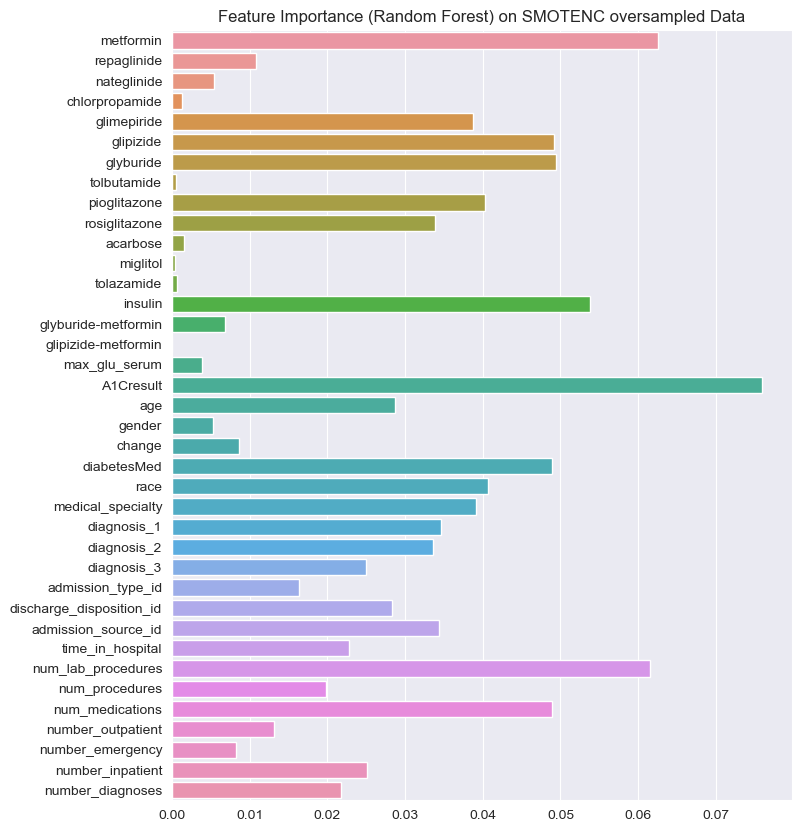

In [22]:
sns.set_style('darkgrid')
plt.figure(figsize=(8,10))
sns.barplot(x=Rf_nc.feature_importances_,y=Rf_nc.feature_names_in_,orient='horizontal')
plt.title("Feature Importance (Random Forest) on SMOTENC oversampled Data")
plt.show()

In [23]:
Feature_imp_rf_nc = pd.DataFrame(data={'Feature':Rf_nc.feature_names_in_,
                                     'Feature_importance':Rf_nc.feature_importances_})

In [24]:
Feature_imp_rf_nc = Feature_imp_rf_nc.sort_values(by='Feature_importance',
                                                ascending=0,ignore_index=True)

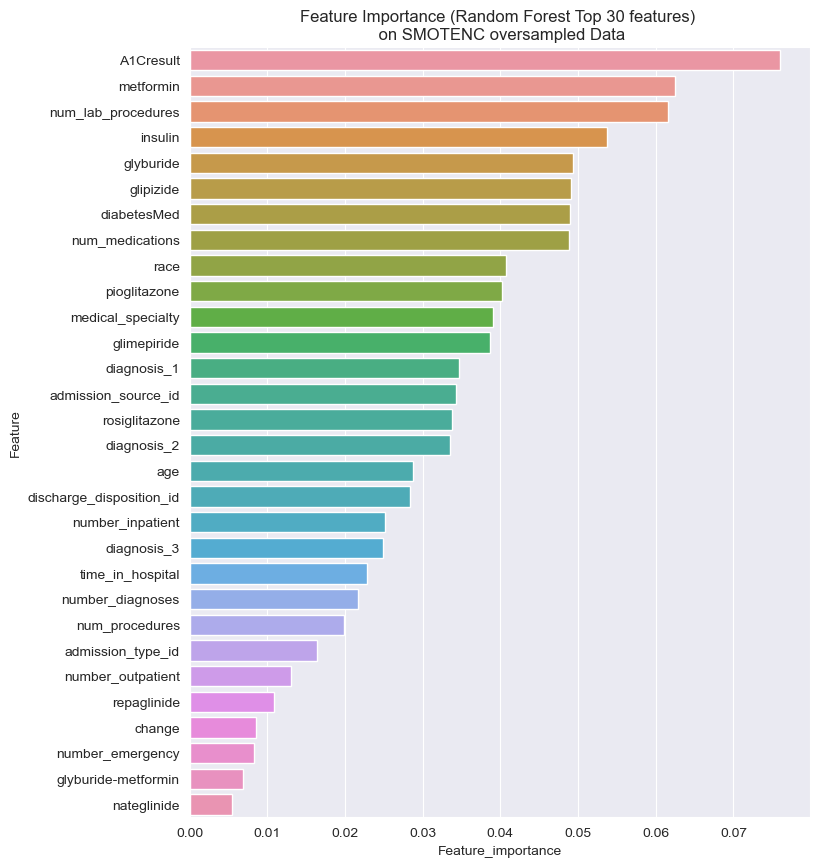

In [25]:
sns.set_style('darkgrid')
plt.figure(figsize=(8,10))
sns.barplot(data=Feature_imp_rf_nc.head(30),x='Feature_importance',y='Feature',orient='horizontal')
plt.title("Feature Importance (Random Forest Top 30 features) \n on SMOTENC oversampled Data")
plt.show()

In [64]:
rf_sub_precision = []
rf_sub_recall = []
rf_f1_score = []
for n_features in range(10,34,2):
    subset_features = Feature_imp_rf_nc.nlargest(n_features,
                                              columns=['Feature_importance'])['Feature'].values
    rf_subset = RandomForestClassifier(n_estimators=80,min_samples_split=45,max_depth=25,
                               max_features=0.65,max_samples=0.65,random_state=93,n_jobs=-1)
    subset_train = X_train[subset_features]
    subset_test = X_test[subset_features]
    subset_train_target = y_train
    subset_test_target = y_test
    rf_subset.fit(subset_train,subset_train_target)
    rf_sub_precision.append(precision_score(subset_test_target,rf_subset.predict(subset_test)))
    rf_sub_recall.append(recall_score(subset_test_target,rf_subset.predict(subset_test)))
    rf_f1_score.append(f1_score(subset_test_target,rf_subset.predict(subset_test)))

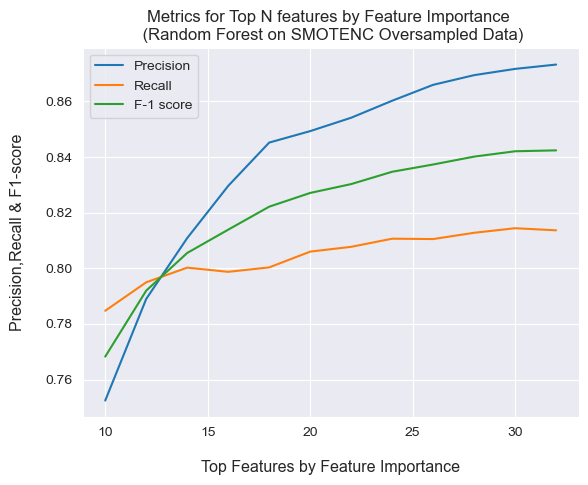

In [65]:
sns.set_style('darkgrid')
sns.lineplot(range(10,34,2),rf_sub_precision,label='Precision')
sns.lineplot(range(10,34,2),rf_sub_recall,label='Recall')
sns.lineplot(range(10,34,2),rf_f1_score,label='F-1 score')

plt.xlabel("Top Features by Feature Importance",fontsize=11.5,labelpad=15)
plt.ylabel("Precision,Recall & F1-score",fontsize=11.5,labelpad=15)
plt.title("Metrics for Top N features by Feature Importance \n (Random Forest on SMOTENC Oversampled Data)")
plt.show()

## `Random Forest after oversampling but dummy encoded`

## `Numericals scaled`

In [32]:
def split_nc(predictor,Target,testing_size=0.25):
        X_train, X_test, y_train, y_test = train_test_split(predictor,Target,test_size=testing_size,
                                                    random_state=93)
        return X_train, X_test, y_train, y_test

In [31]:
def cv_report_nc(Model,Training_data,Target_balanced):
    X_train, X_test, y_train, y_test = train_test_split(Training_data,Target_balanced,
                                                        test_size=0.25, random_state=42)
    ba = cross_val_score(Model,X_train,y_train,cv=5,
                         scoring='balanced_accuracy').mean()
    pr = cross_val_score(Model,X_train,y_train,cv=5,scoring='precision').mean()
    re = cross_val_score(Model,X_train,y_train,cv=5,scoring='recall').mean()
    f1 = cross_val_score(Model,X_train,y_train,cv=5,scoring='f1').mean()
    print("Metric            :  percentage")
    print("-"*35)
    print(f"Balanced accuracy :  {ba*100:0.2f} %")
    print(f"Precision         :  {pr*100:0.2f} %")
    print(f"recall            :  {re*100:0.2f} %")
    print(f"F1-score          :  {f1*100:0.2f} %")

In [26]:
link_over = 'F:\GREAT LAKES\PROJECT\Different_datasets\Random Forest\SMOTENC_Dummy_encoded_data(reduced_size).csv'

In [27]:
df_over = pd.read_csv(link_over)
df_over = df_over.iloc[:,1:]

predictors_balanced = df_over.drop('readmitted',1)
Target_balanced = df_over[['readmitted']]

In [28]:
patient_info = ['race', 'gender', 'age', 'admission_type_id',
                'discharge_disposition_id','admission_source_id',
                'medical_specialty','diagnosis_1','diagnosis_2', 'diagnosis_3',
                'max_glu_serum', 'A1Cresult','change', 'diabetesMed']

# Features which contains no information
drop_list_patient_info = ['encounter_id','patient_nbr','weight','payer_code']

# Numeric features
patient_info_numeric = ['time_in_hospital','num_lab_procedures',
                        'num_procedures','num_medications',
                        'number_outpatient','number_emergency',
                        'number_inpatient','number_diagnoses']

# Taking initial decision to keep 16 features
feature_medicine = ['metformin','repaglinide', 'nateglinide', 
                     'chlorpropamide', 'glimepiride', 'glipizide', 
                     'glyburide', 'tolbutamide','pioglitazone',
                     'rosiglitazone', 'acarbose', 'miglitol','tolazamide',
                     'insulin','glyburide-metformin', 'glipizide-metformin']

# Initial decision to remove 7 features
drop_list_medicine = ['acetohexamide','troglitazone','examide','citoglipton',
                      'glimepiride-pioglitazone','metformin-rosiglitazone',
                      'metformin-pioglitazone']


# The medicines which contains 'Steady' & 'No' for encoding purpose
two_category_medicine = ['acetohexamide', 'tolbutamide', 'troglitazone',
                         'glipizide-metformin', 'glimepiride-pioglitazone',
                         'metformin-rosiglitazone', 'metformin-pioglitazone']
# ------------------------------------------------------------------
# The medicines which contains 'Steady','Up','Down' & 'No' for encoding purpose (14)
four_category_medicine = ['metformin','repaglinide', 'nateglinide', 'chlorpropamide',
                          'glimepiride','glipizide','glyburide','pioglitazone','rosiglitazone',
                          'acarbose','miglitol','tolazamide','insulin','glyburide-metformin'] 
# ------------------------------------------------------------------
# considering these two medicines with only 'steady' & 'No' categories for encoding purpose
two_category_medicine_to_be_kept = ['tolbutamide','glipizide-metformin']
# ------------------------------------------------------------------                                                
# Out of initial removal decision, these 2 are compulsorily removed.
single_category_medicine = ['examide', 'citoglipton']
                                             

print(set(drop_list_medicine) & set(two_category_medicine))

dependent = 'readmitted'

{'acetohexamide', 'metformin-pioglitazone', 'glimepiride-pioglitazone', 'troglitazone', 'metformin-rosiglitazone'}


In [36]:
chi_significant = []
for feature in predictors_balanced.columns.difference(patient_info_numeric)[:-1]:
    p_value = stats.chi2_contingency(pd.crosstab(df_over[feature],df_over['readmitted']))[1]
    result = {True : "Significant",False : "Insignificant"}[p_value < 0.05]
    if result == 'Significant':
        chi_significant.append(feature)
        print(f"{feature:50s} : {result}")

A1Cresult_>7                                       : Significant
A1Cresult_>8                                       : Significant
A1Cresult_None                                     : Significant
A1Cresult_Norm                                     : Significant
acarbose_No                                        : Significant
acarbose_Steady                                    : Significant
admission_source_id_Emergency                      : Significant
admission_source_id_Referral                       : Significant
admission_source_id_other                          : Significant
admission_type_id_Elective                         : Significant
admission_type_id_Emergency                        : Significant
admission_type_id_No mention                       : Significant
admission_type_id_Urgent                           : Significant
admission_type_id_others                           : Significant
age_[0-10)                                         : Significant
age_[10-20)              

In [37]:
len(chi_significant)

122

In [38]:
X_train, X_test, y_train, y_test = split_nc(predictors_balanced[chi_significant[:100]+patient_info_numeric],Target_balanced,testing_size=0.25)

In [39]:
rf_dummy = RandomForestClassifier(n_estimators=150,random_state=93,min_samples_split=50,
                                  max_features=0.6,max_samples=0.75,oob_score=True,
                                  max_depth=25,n_jobs=-1)

In [40]:
rf_dummy.fit(X_train,y_train)

RandomForestClassifier(max_depth=25, max_features=0.6, max_samples=0.75,
                       min_samples_split=50, n_estimators=150, n_jobs=-1,
                       oob_score=True, random_state=93)

In [41]:
rf_dummy.oob_score_

0.9163234353857821

In [93]:
print(classification_report(y_train,rf_dummy.predict(X_train)))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93     67220
           1       0.99      0.86      0.92     67286

    accuracy                           0.93    134506
   macro avg       0.93      0.93      0.93    134506
weighted avg       0.93      0.93      0.93    134506



In [98]:
cv_report_nc(rf_dummy,X_train,y_train)

Metric            :  percentage
-----------------------------------
Balanced accuracy :  90.90 %
Precision         :  98.25 %
recall            :  83.28 %
F1-score          :  90.15 %


In [72]:
print(classification_report(y_test,rf_dummy.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.99      0.92     22451
           1       0.99      0.85      0.91     22385

    accuracy                           0.92     44836
   macro avg       0.93      0.92      0.92     44836
weighted avg       0.93      0.92      0.92     44836



In [169]:
# cv_report_nc(rf_dummy,X_train,y_train)

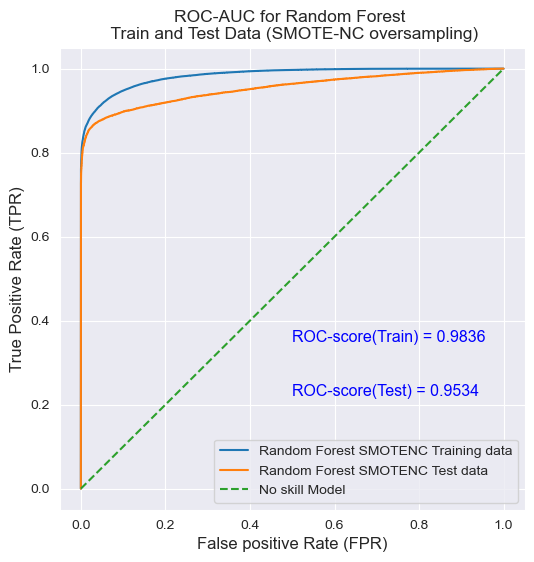

In [94]:
fpr, tpr, _ = roc_curve(y_train,rf_dummy.predict_proba(X_train)[:,1])
fpr1, tpr1, _ = roc_curve(y_test,rf_dummy.predict_proba(X_test)[:,1])

fig,ax = plt.subplots(figsize=(6,6))
sns.set_style('darkgrid')
plt.plot(fpr,tpr,label='Random Forest SMOTENC Training data')
plt.plot(fpr1,tpr1,label='Random Forest SMOTENC Test data')
sns.lineplot([0,1],[0,1],label='No skill Model',ls='--')
plt.xlabel("False positive Rate (FPR)",fontsize=12.0)
plt.ylabel("True Positive Rate (TPR)",fontsize=12.0)
plt.text(0.50,0.35,s=f"ROC-score(Train) = {roc_auc_score(y_train,rf_dummy.predict_proba(X_train)[:,1]):0.4f}",
        fontsize=11.5,color='blue')
plt.text(0.50,0.22,s=f"ROC-score(Test) = {roc_auc_score(y_test,rf_dummy.predict_proba(X_test)[:,1]):0.4f}",
        fontsize=11.5,color='blue')
plt.title('ROC-AUC for Random Forest \n Train and Test Data (SMOTE-NC oversampling)',fontsize=12.5)
plt.show()

In [43]:
Feature_imp_rf_dummy = pd.DataFrame(data={'Feature':rf_dummy.feature_names_in_,
                                     'Feature_importance':rf_dummy.feature_importances_})

In [44]:
Feature_imp_rf_dummy = Feature_imp_rf_dummy.sort_values(by='Feature_importance',
                                                ascending=0,ignore_index=True)

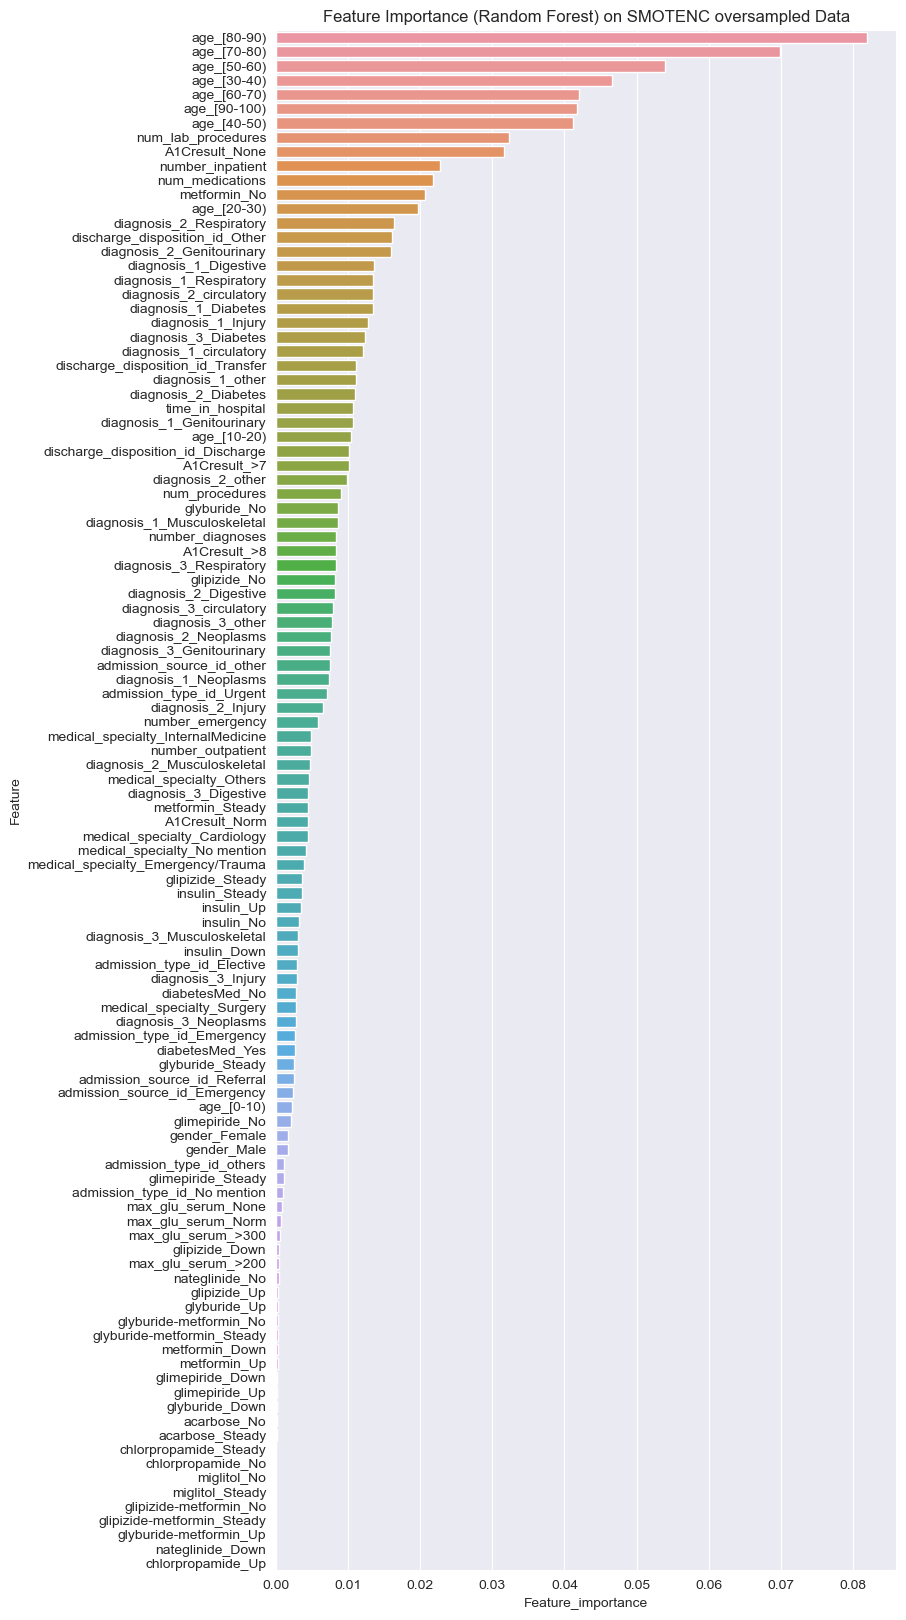

In [97]:
plt.figure(figsize=(8,20))
sns.barplot(x=Feature_imp_rf_dummy['Feature_importance'],y=Feature_imp_rf_dummy['Feature'],orient='horizontal')
plt.title("Feature Importance (Random Forest) on SMOTENC oversampled Data")
plt.show()

In [45]:
rf_sub_precision = []
rf_sub_recall = []
rf_f1_score = []
for n_features in range(10,140,10):
    subset_features = Feature_imp_rf_dummy.nlargest(n_features,
                                              columns=['Feature_importance'])['Feature'].values
    rf_subset = RandomForestClassifier(n_estimators=100,random_state=93,min_samples_split=50,
                                  max_features=0.6,max_samples=0.80,oob_score=True,
                                  max_depth=30,n_jobs=-1)
    subset_train = X_train[subset_features]
    subset_test = X_test[subset_features]
    subset_train_target = y_train
    subset_test_target = y_test
    rf_subset.fit(subset_train,subset_train_target)
    rf_sub_precision.append(precision_score(subset_test_target,rf_subset.predict(subset_test)))
    rf_sub_recall.append(recall_score(subset_test_target,rf_subset.predict(subset_test)))
    rf_f1_score.append(f1_score(subset_test_target,rf_subset.predict(subset_test)))

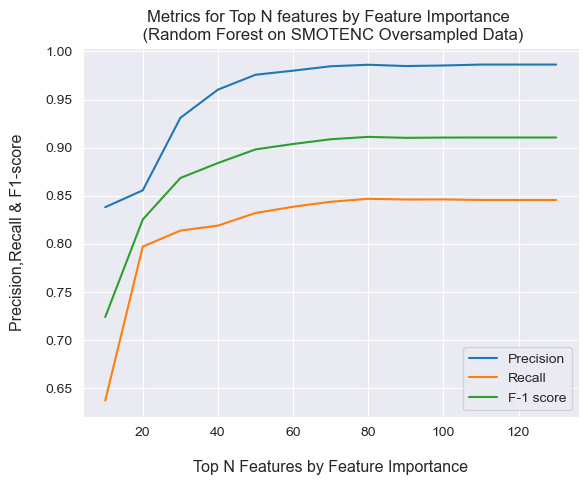

In [46]:
sns.set_style('darkgrid')
sns.lineplot(range(10,140,10),rf_sub_precision,label='Precision')
sns.lineplot(range(10,140,10),rf_sub_recall,label='Recall')
sns.lineplot(range(10,140,10),rf_f1_score,label='F-1 score')

plt.xlabel("Top N Features by Feature Importance",fontsize=11.5,labelpad=15)
plt.ylabel("Precision,Recall & F1-score",fontsize=11.5,labelpad=15)
plt.title("Metrics for Top N features by Feature Importance \n (Random Forest on SMOTENC Oversampled Data)")
plt.show()

In [53]:
Feature_imp_rf_dummy_80 = Feature_imp_rf_dummy.sort_values(by='Feature_importance',
                                                ascending=0,ignore_index=True).head(80)

In [54]:
X_train, X_test, y_train, y_test = split_nc(predictors_balanced[Feature_imp_rf_dummy_80['Feature'].values],
                                            Target_balanced,testing_size=0.25)

In [55]:
rf_dummy_80 = RandomForestClassifier(n_estimators=100,random_state=93,min_samples_split=50,
                                  max_features=0.6,max_samples=0.75,oob_score=True,
                                  max_depth=25,n_jobs=-1)
rf_dummy_80.fit(X_train,y_train)

RandomForestClassifier(max_depth=25, max_features=0.6, max_samples=0.75,
                       min_samples_split=50, n_jobs=-1, oob_score=True,
                       random_state=93)

In [134]:
def classifier_report(Model,predictors,Actual,prob_threshold=0.5):
    predictions = np.where(Model.predict_proba(predictors)[:,1]>prob_threshold,1,0)
    print(classification_report(Actual,predictions))

In [56]:
rf_dummy_80.oob_score_

0.915862489405677

In [57]:
print(classification_report(y_train,rf_dummy_80.predict(X_train)))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93     67220
           1       0.99      0.86      0.92     67286

    accuracy                           0.92    134506
   macro avg       0.93      0.92      0.92    134506
weighted avg       0.93      0.92      0.92    134506



In [64]:
def Balanced_metrics(Model,predictors,Actual,prob_threshold=0.5):
    predictions = np.where(Model.predict_proba(predictors)[:,1] > prob_threshold,1,0)
    f1 = f1_score(Actual,predictions)
    precision = precision_score(Actual,predictions)
    recall = recall_score(Actual,predictions)
    return precision,recall,f1

In [59]:
def threshold_plot(Model,X_train,y_train,title):
    probabilty_thresholds = np.arange(0.1,0.5,0.01)
    plotting_dict = dict()
    for prob in probabilty_thresholds:
        metric_1,metric_2,metric_3 = Balanced_metrics(Model,X_train,y_train,prob_threshold=prob)
        plotting_dict[prob] = metric_1,metric_2,metric_3

    plt.figure(figsize=(6,5))
    for label,values in zip(['precision','recall','f1-score'],list(zip(*tuple(plotting_dict.values())))):
        sns.lineplot(probabilty_thresholds,values,label=label)
    plt.title(title)
    plt.xlabel("Probability Thresholds",fontsize=12.0)
    plt.ylabel("Precision, Recall & F1 score",fontsize=12.0)
    return plt.show()

In [66]:
title = 'Various Metrics for different probability thresholds \n (Random Forest Top 80 features) (Oversampled data)'

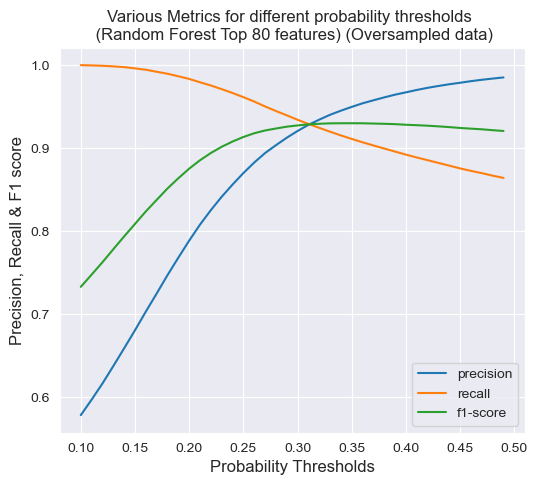

In [67]:
threshold_plot(rf_dummy_80,X_train,y_train,title)

# `Feature Engineering`

In [88]:
link_smote = 'F:\GREAT LAKES\PROJECT\Different_datasets\Original_iterative_imputed_SMOTENC_data\Original_SMOTENC_after_imputation_1790000.csv'

In [89]:
df_smote = pd.read_csv(link_smote)
df_smote = df_smote.iloc[:,1:]

### `Health_index`

In [90]:
# Health_index = 1 / (number_emergency + number_inpatient + number_outpatient)
# severity_of_disease = (time_in_hospital(in days) + num_procedures + num_medications + num_lab_procedures + number_of_diagnoses)

In [91]:
# Based on frequency of patient’s visit to the hospital is high 
# then we can say that patient is less healthier and 
# less healthier patient tends to readmit quickly. 
# Higher the health_index lesser the chance that person will readmit (inversely proportional)

In [92]:
hospital_data = (df_smote['number_outpatient'] + df_smote['number_emergency'] + df_smote['number_inpatient'])
health_index = hospital_data

# for some of the patients there is no visit, hence denominator = 0 let's make health index as 1
health_index.loc[health_index == np.inf] = 1

### `severity of disease`

In [93]:
# Severity of disease  is the feature created based on time spent in hospital, 
# number of procedures, medications taken by patient. 
# For probabilistic interpretation we divided it by total values.

severity = (df_smote['time_in_hospital'] + df_smote['num_lab_procedures'] + df_smote['num_procedures'] + df_smote['num_medications'] + df_smote['number_diagnoses'])

severity_of_disease = severity

In [94]:
health_index_std = pd.DataFrame(health_index,columns=['Health_index'])
severity_of_disease_std = pd.DataFrame(severity_of_disease,columns=['Severity_of_disease'])

In [1]:
# health_index_std = health_index.to_frame().apply(zscore)
# severity_of_d isease_std = severity_of_disease.to_frame().apply(zscore)

In [95]:
# lets add 'severity index' & 'health_index' to SMOTE resampled data

predictor_nc_f = pd.concat([predictors_balanced[Feature_imp_rf_dummy_50['Feature'].values],
                            health_index_std,severity_of_disease_std],axis=1)
Target_nc_f = Target_balanced

In [96]:
X_train, X_test, y_train, y_test = split_nc(predictor_nc_f,Target_nc_f,testing_size=0.25)

In [97]:
rf_dummy_fe = RandomForestClassifier(n_estimators=100,random_state=93,min_samples_split=50,
                                  max_features=0.6,max_samples=0.75,oob_score=True,
                                  max_depth=25,n_jobs=-1)
rf_dummy_fe.fit(X_train,y_train)

RandomForestClassifier(max_depth=25, max_features=0.6, max_samples=0.75,
                       min_samples_split=50, n_jobs=-1, oob_score=True,
                       random_state=93)

In [98]:
rf_dummy_fe.oob_score_

0.9110969027403982

In [99]:
print(classification_report(y_train,rf_dummy_fe.predict(X_train)))

              precision    recall  f1-score   support

           0       0.87      0.98      0.93     67220
           1       0.98      0.86      0.92     67286

    accuracy                           0.92    134506
   macro avg       0.93      0.92      0.92    134506
weighted avg       0.93      0.92      0.92    134506



In [100]:
def medicine_taking(row):
    row = [0 if category == 'No' else 1 for category in row.tolist()]
    return row

def therapy(x):
    if x == 0:
        return 'No treatment'
    elif x == 1:
        return 'Monotherapy'
    else:
        return 'Combination therapy'

df_therapy = df_smote[feature_medicine].apply(medicine_taking)
Therapy = df_therapy.apply(np.sum,axis=1)
Therapy_df = pd.DataFrame(Therapy.apply(therapy),columns=['Therapy'])

In [101]:
Therapy_df_dummy = pd.get_dummies(Therapy_df)

In [102]:
predictor_nc_f1 = pd.concat([predictor_nc_f,Therapy_df_dummy],axis=1)
Target_nc_f1 = Target_balanced

In [103]:
X_train, X_test, y_train, y_test = split_nc(predictor_nc_f1,Target_nc_f1,testing_size=0.25)

In [104]:
rf_dummy_fe1 = RandomForestClassifier(n_estimators=100,random_state=93,min_samples_split=50,
                                  max_features=0.6,max_samples=0.75,oob_score=True,
                                  max_depth=25,n_jobs=-1)
rf_dummy_fe1.fit(X_train,y_train)

RandomForestClassifier(max_depth=25, max_features=0.6, max_samples=0.75,
                       min_samples_split=50, n_jobs=-1, oob_score=True,
                       random_state=93)

In [105]:
print(classification_report(y_test,rf_dummy_fe1.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92     22451
           1       0.98      0.84      0.90     22385

    accuracy                           0.91     44836
   macro avg       0.92      0.91      0.91     44836
weighted avg       0.92      0.91      0.91     44836



### `Transforming age to 3 categories`

In [106]:
def age_encoding(x):
    if int(x.strip('[)').split("-")[1]) == 30:
        return '[0-30]'
    elif int(x.strip('[)').split("-")[1]) == 60:
        return '[30-60]'
    else:
        return '[60-100]'

In [107]:
age = df_smote['age'].apply(age_encoding)
age_dummy = pd.get_dummies(age)

In [108]:
predictor_nc_age = predictor_nc_f.drop(columns=predictor_nc_f.filter(like='age_').columns)
predictor_nc_age = pd.concat([predictor_nc_age,age_dummy],axis=1)
Target_nc_age = Target_balanced

In [109]:
X_train, X_test, y_train, y_test = split_nc(predictor_nc_age,Target_nc_age,testing_size=0.25)

In [110]:
rf_dummy_age = RandomForestClassifier(n_estimators=100,random_state=93,min_samples_split=40,
                                  max_features=0.75,max_samples=0.75,oob_score=True,
                                  max_depth=25,n_jobs=-1)
rf_dummy_age.fit(X_train,y_train)

RandomForestClassifier(max_depth=25, max_features=0.75, max_samples=0.75,
                       min_samples_split=40, n_jobs=-1, oob_score=True,
                       random_state=93)

In [111]:
print(classification_report(y_test,rf_dummy_age.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.96      0.90     22451
           1       0.95      0.84      0.89     22385

    accuracy                           0.90     44836
   macro avg       0.90      0.90      0.90     44836
weighted avg       0.90      0.90      0.90     44836

